# Download and extract data

In [1]:
# Clone necessary files
!git clone https://github.com/ichatnun/MCI-multiple-drawings-PyTorch.git
!mv MCI-multiple-drawings-PyTorch/* .
!rm -r MCI-multiple-drawings-PyTorch sample_data

# Create the data folder: 'MCI-multiple-drawings-PyTorch/data'
!mkdir data
!mkdir data/multiDrawingMCI2022

# Download the data and corresponding labels
!wget -P data/multiDrawingMCI2022/ https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
!wget -O images.zip https://github.com/cccnlab/MCI-multiple-drawings/raw/main/images.zip
!unzip -q images.zip -d data/multiDrawingMCI2022/
!rm images.zip

Cloning into 'MCI-multiple-drawings-PyTorch'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 150 (delta 66), reused 110 (delta 34), pack-reused 0
Receiving objects: 100% (150/150), 701.82 KiB | 16.32 MiB/s, done.
Resolving deltas: 100% (66/66), done.
--2023-09-21 16:07:37--  https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv [following]
--2023-09-21 16:07:37--  https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import necessary modules

In [3]:
import sys, os
import numpy as np
import torch

import matplotlib.pyplot as plt

from dataloader.getDataloaders import getDataloaders
from utils.utils import testDataloader
from models.getModel import getModel

import lightning as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Specify parameters

In [4]:
# Create a dictionary to store additional info
add_info = {'dataset_name': 'multiDrawingMCI',
            'idx2class_dict': {'0': 'control', '1': 'mci'},
            'healthy_threshold': 25, # MoCA score of >= 25-> healthy
            'batch_size': 8}
add_info['class_list'] = [add_info['idx2class_dict'][key] for key in add_info['idx2class_dict'].keys()]
add_info['num_classes'] = len(add_info['idx2class_dict'].keys())

# Available tasks: 'clock', 'copy', 'trail'
add_info['task_list'] = ['clock', 'copy', 'trail']

# Create the results folder
add_info['results_dir'] = os.path.join(os.getcwd(), 'results')
os.makedirs(add_info['results_dir'], exist_ok=True)

In [5]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = AttributeDict()
args.val_fraction = 0.15
args.test_fraction = 0.15
args.random_seed = 28
args.label_type = 'hard' # Available options: 'raw', 'hard', 'soft'
args.use_pretrained_weight = False
args.freeze_backbone = False
args.num_workers = 2
args.model_name = 'vgg16'
args.num_epochs = 100

## Check arguments

In [6]:
# Check val and test fractions
if args.val_fraction + args.test_fraction >= 1:
    print('Invalid training fraction')
    sys.exit(1)

# Create training, validation, and test DataLoaders

In [7]:
dataloader_dict = getDataloaders(args, add_info)

# Test one of the created DataLoaders using the provided function

It gets a sample batch and saves the images and corresponding labels in the 'results' folder

*   test_loader_sample_data_batch.png
*   test_loader_sample_label_batch.csv



The clock data are in the range (0.0, 1.0)
The copy data are in the range (0.0, 1.0)
The trail data are in the range (0.0, 1.0)


<Figure size 800x800 with 0 Axes>

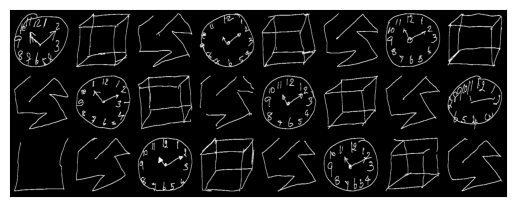

In [8]:
testDataloader(dataloader_dict['test'],
                add_info['results_dir'],
                add_info['batch_size'],
                add_info['task_list'])

# Try getting a batch from the training DataLoader manually

In [9]:
curr_data_batch, curr_label_batch = next(iter(dataloader_dict['train']))

## Extract some information from the batch

****************** clock ******************
Data: torch.Size([8, 3, 256, 256])
Labels: torch.Size([8, 2])
The R, G, and B channels are identical


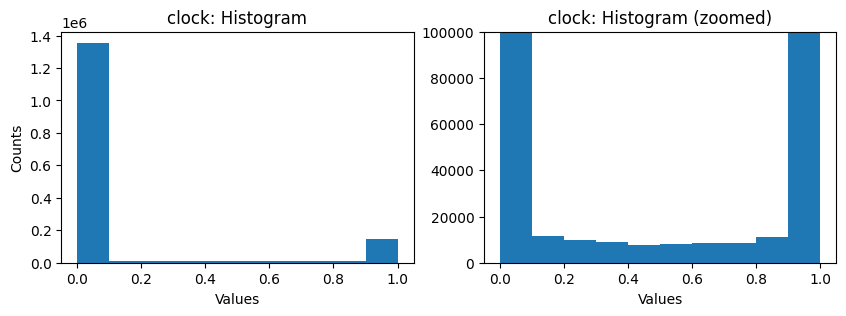

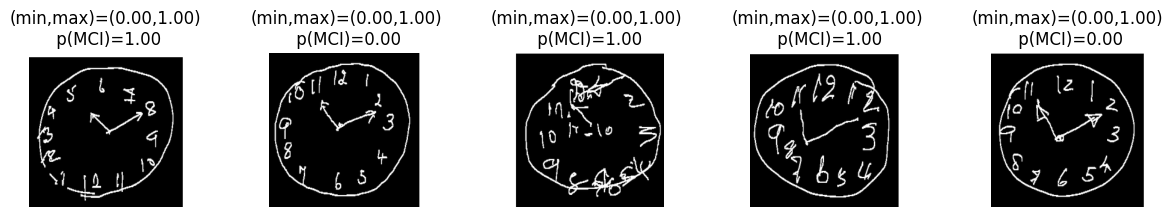



****************** copy ******************
Data: torch.Size([8, 3, 256, 256])
Labels: torch.Size([8, 2])
The R, G, and B channels are identical


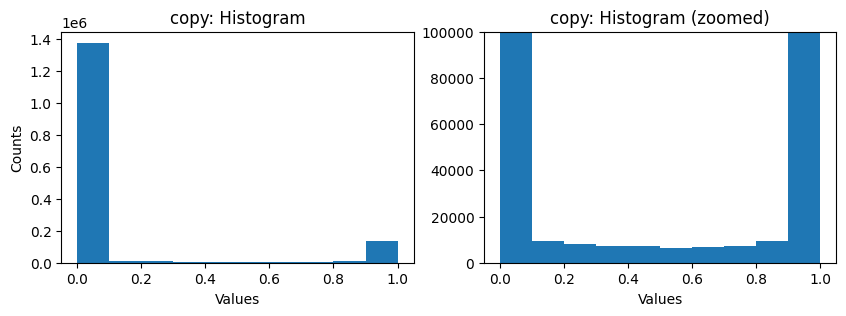

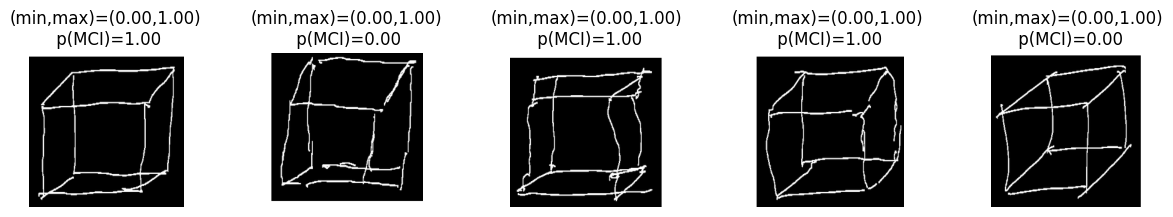



****************** trail ******************
Data: torch.Size([8, 3, 256, 256])
Labels: torch.Size([8, 2])
The R, G, and B channels are identical


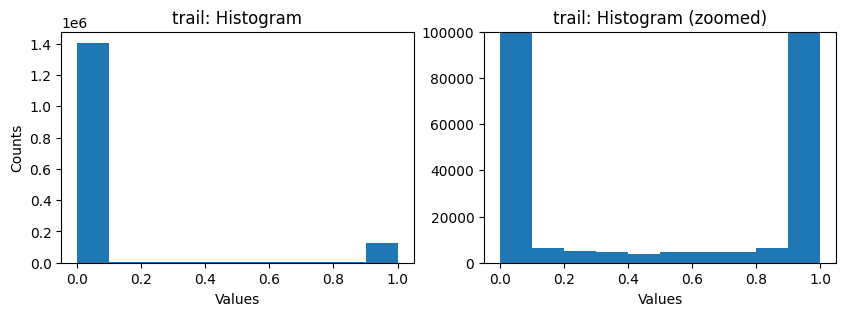

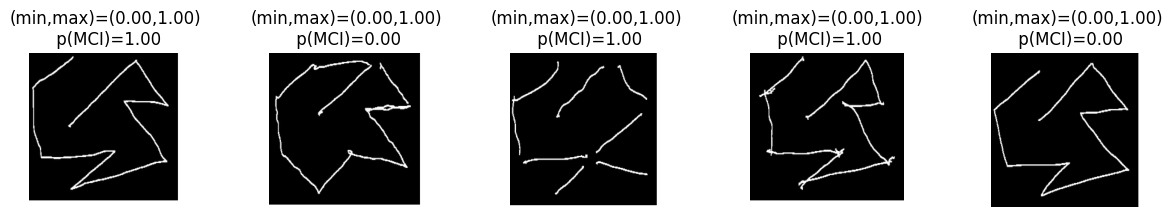

In [10]:
# Specify # of images to be displayed (per task)
num_display_imgs = min(5, add_info['batch_size'])

for curr_task in add_info['task_list']:

    print(f"****************** {curr_task} ******************")
    # Extract the data from the first task (given by add_info['task_list'][0])
    data_one_task = curr_data_batch[curr_task]

    # Check the dimensions
    print(f"Data: {data_one_task.shape}")
    print(f"Labels: {curr_label_batch.shape}")

    # Check if the R, G, and B channels are identical
    is_rg_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 1, :, :])
    is_rb_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 2, :, :])
    is_gb_equal = torch.equal(data_one_task[:, 1, :, :], data_one_task[:, 2, :, :])

    if is_rg_equal and is_rb_equal and is_gb_equal:
        print("The R, G, and B channels are identical")
    else:
        print("The R, G, and B channels contain different values")

    # Plot the histogram of the pixel values
    data_flatten = data_one_task.numpy().reshape(-1,)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(data_flatten)
    plt.ylabel('Counts')
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram")

    plt.subplot(1, 2, 2)
    plt.hist(data_flatten)
    plt.ylim(0, 1e5)
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram (zoomed)")

    # Display the first five images of each task in the batch
    plt.figure(figsize=(num_display_imgs*3, 2))
    for idx_img in range(num_display_imgs):

        # Extract an image
        curr_img = data_one_task.numpy()[idx_img].transpose(1, 2, 0)

        # Plot the image
        plt.subplot(1, num_display_imgs, idx_img + 1)
        plt.imshow(curr_img)
        plt.axis('off')

        if args.label_type in ['hard', 'soft']:
            plt.title(f"(min,max)=({np.min(curr_img):0.2f},{np.max(curr_img):0.2f})\n p(MCI)={curr_label_batch[idx_img, 1]:0.2f}")
        elif args.label_type == 'raw':
            plt.title(f"(min,max)=({np.min(curr_img):0.2f},{np.max(curr_img):0.2f})\n MoCA={curr_label_batch[idx_img]}")

    plt.show()
    print("\n")

In [11]:
model = getModel(args.model_name, add_info["num_classes"], add_info["task_list"], args.use_pretrained_weight, args.freeze_backbone)

# Define the loss function
if args.label_type in ['hard', 'soft']:
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
elif args.label_type == 'raw':
    add_info['num_classes'] = 1
    loss_fn = torch.nn.MSELoss(reduction='mean')

In [12]:
# Define the LightningModule
class LitVGG16(pl.LightningModule):

    def __init__(self, model, loss_fn):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.softmax = torch.nn.Softmax(dim=1)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        logits_predicted = self.model(x) # Without softmax

        loss = self.loss_fn(logits_predicted, y)

        # Log results
        self.log("train_loss", loss)

        return loss

    def forward(self, x):
        logits_predicted = self.model(x) # Without softmax
        return self.softmax(logits_predicted)


    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        logits_predicted = self.model(x) # Without softmax

        loss = self.loss_fn(logits_predicted, y)

        # Log results
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Create the model
model = LitVGG16(model, loss_fn)

# Prepare logger
logger = CSVLogger(save_dir=add_info['results_dir'])
# logger = TensorBoardLogger(save_dir=add_info['results_dir'])

# Prepare callbacks
checkpoint_callback = ModelCheckpoint(dirpath=add_info['results_dir'],
                                      filename='{epoch}-{val_loss:.2f}',
                                      save_top_k=1,
                                      every_n_epochs=1)

In [ ]:
# Train the model
trainer = pl.Trainer(max_epochs=args.num_epochs,
                      logger=logger,
                      callbacks=[checkpoint_callback],
                      devices=[0],
                      accelerator="gpu",
                      log_every_n_steps=10)

In [ ]:
trainer.fit(model=model,
            train_dataloaders=dataloader_dict['train'],
            val_dataloaders=dataloader_dict['val'])